In [ ]:
# We create an artificial social network with two classes: influence and non-influencer.
#
# Influencer nodes have node properties which are sampled from an 'influencer' biased distribution.
# Non-influencer nodes have properties which are samples from 'non-influencer' biased distributions.
#
# We use these social graphs to generate artificial data where we can control the level of noise (variance) between samples.
# This data will be used to design and train a node-classification GNN using a message passing framework.
#
# In this particular use case, we will create undirected graphs which represent artificially generated social circles.
# Specifically, the social circles we'll be generating will model Motorcycle Riders at a University.
# For example, a 100 node graph will represent a social structure of 100 different riders from the same university. 
# The existence of an edge between nodes indicates mutual connection (friends, same club, same class, etc.)
# The actual node feature data will include general information about the social media profile of each of these riders.
# Naturally, the riders who are also 'influencers' will express features that more closely demonstrate that:
#   - More posts per day
#   - More likes per post
#   - Higher clustering coefficient within the sampled social circle
#   - etc.
#
# Our goal is to create a GNN which can adequately classify a given node as either an influencer or a noninfluencer.
#
# Node Features (11-dimensions): 
#   - Normalized node degree
#   - Clustering coefficient
#   - Average posts per day
#   - Average likes per post
#   - Follower/Following ratio
#   - Age
#   - Years Riding
#   - Miles Riding
#   - Engine Size
#   - Number of Motorcycles Owned
#   - Average bike MSRP

In [178]:
# Imports
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
from collections import deque
import networkx as nx   # For drawing the graphs
import random

In [112]:
# Distribution characteristics

# This is the mean proportion of riders who are also influencers expressed as a percentage, sampled from normal
INFL_PROP_MEAN  = 10 # On average, 10% of riders are influencers
INFL_PROP_DEV   = 2  # This is the standard deviation

# For each node, the normalized degree and clustering coefficient are calculated from the graph topology 

# These are the parameters used to generate the 'influencer' node data
INFL_POSTS_MEAN = 1 # On average, influencers post this many times a day
INFL_POSTS_DEV  = 0.5 

INFL_LIKES_MEAN = 1000 # On average, influencers get this many likes per post
INFL_LIKES_DEV  = 200

INFL_RATIO_MEAN = 5 # On average, this is the followers/following ratio for influencers
INFL_RATIO_DEV  = 2

INFL_AGE_MEAN   = 23 # On average, this is the average age for influencers
INFL_AGE_DEV    = 5

INFL_YEARS_MEAN = 3 # On average, influencers have this number of years' riding experience
INFL_YEARS_DEV  = 2

INFL_MILES_MEAN = 2000 # On average, influencers have this many miles of riding experience
INFL_MILES_DEV  = 500

INFL_BIKES_MEAN = 4 # On average, influencers own this many motorcycles
INFL_BIKES_DEV  = 2

INFL_DISP_MEAN  = 800 # On average, influencers own bikes with this displacement
INFL_DISP_DEV   = 200

INFL_MSRP_MEAN  = 25000 # On average, the MSRP of an influencer's bike is this amount
INFL_MSRP_DEV   = 10000

# These are the parameters used to generate the 'non-influencer' node data
NON_POSTS_MEAN  = 0.1 # On average, non-influencers post this many times a day
NON_POSTS_DEV   = 0.05 

NON_LIKES_MEAN  = 200 # On average, non-influencers get this many likes per post
NON_LIKES_DEV   = 50

NON_RATIO_MEAN  = 1 # On average, this is the followers/following ratio for non-influencers
NON_RATIO_DEV   = 0.2

NON_AGE_MEAN    = 30 # On average, this is the average age for non-influencers
NON_AGE_DEV     = 10

NON_YEARS_MEAN  = 5 # On average, non-influencers have this number of years' riding experience
NON_YEARS_DEV   = 3

NON_MILES_MEAN  = 5000 # On average, non-influencers have this many miles of riding experience
NON_MILES_DEV   = 2000

NON_BIKES_MEAN  = 2 # On average, non-influencers own this many motorcycles
NON_BIKES_DEV   = 1

NON_DISP_MEAN   = 600 # On average, non-influencers own bikes with this displacement
NON_DISP_DEV    = 200

NON_MSRP_MEAN   = 20000 # On average, the MSRP of an non-influencers price is this amount
NON_MSRP_DEV    = 6000



In [113]:
def visualize_graph_bfs(A, layout="spring", k=1.0, base_color=(0.7, 0.7, 0.7), node_size=100):
    """
    Visualize BFS on an undirected graph given its adjacency matrix.
    When the graph is displayed, clicking on a src node will present BFS as a color gradient

    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix (assumed undirected, with self-loops allowed).
    layout : str, optional
        Layout type: "spring", "circular", or "kamada_kawai".
    k: float, optional
        Optimal distance between nodes
    base_color: tuple, optional
        Color of base nodes
    node_size : int, optional
        Size of nodes in the plot.
    """
    
    # Build graph
    G = nx.from_numpy_array(A)
    N = G.number_of_nodes()

    # 2. Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, k=k)          # force-directed layout
    elif layout == "circular":
        pos = nx.circular_layout(G, k=k)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, k=k)
    else:
        raise ValueError(f"Unknown layout: {layout}")
    
    # 3. Initial node colors
    node_colors = [base_color] * N

    # 3. Draw
    fig, ax = plt.subplots(figsize=(5, 5))
    # Draw nodes, edges, labels separately so we can update nodes later
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                   node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    plt.title("Random Graph")
    plt.axis("off")
    plt.tight_layout()

    def on_click(event):
        if event.inaxes is not ax:
            return
        
        click_xy = np.array([event.xdata, event.ydata])

        # Find nearest node
        #min_dist = float("inf")
        min_dist = 0.1
        nearest_node = None
        for n, (x, y) in pos.items():
            dist = np.linalg.norm(click_xy - np.array([x, y]))
            if dist < min_dist:
                min_dist = dist
                nearest_node = n

        # Reset graph colors if click on empty space
        if nearest_node is None:
            for i in range(N):
                node_colors[i] = base_color

            nodes.set_facecolor(node_colors)
            return

        distances = bfs(A, nearest_node)
        max_distance = max(distances)

        # Update node colors based on BFS
        for i in range(N):
            if(distances[i] == -1):
                node_colors[i] = base_color
            else:
                node_colors[i] = (1.0, 0.0 + (distances[i]) / (max_distance + 2), 0.0) # Red scale

        nodes.set_facecolor(node_colors)

        # Update title so we know something happened
        ax.set_title(f"Source node: {nearest_node}")

        # Redraw
        fig.canvas.draw_idle()

    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.show()

In [114]:
def visualize_biker_data(G, isInfluencer, feature, labels, bins=20):
    """
    Plot the distribution of a given node feature for influencer or non-influencer nodes.

    Parameters:
        G (networkx.Graph): graph containing node features
        isInfluencer (bool): True to plot influencers, False for non-influencers
        feature (str): the node feature to visualize (e.g., 'age', 'likes_per_post')
        labels (np.ndarray): binary array of 0/1 influencer labels
        bins (int): number of histogram bins
    """

    # Determine which label value we want
    target_label = 1 if isInfluencer else 0

    # Collect values for the chosen feature
    values = []

    for i in G.nodes():
        if labels[i] == target_label:
            values.append(G.nodes[i][feature])

    # Sanity check
    if len(values) == 0:
        print("No nodes found with the given label.")
        return

    # Plot histogram
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)

    label_text = "Influencers" if isInfluencer else "Non-influencers"
    plt.title(f"{label_text} - Feature: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.25)
    plt.show()

In [115]:
def bfs(A, src):
    """
    Perform BFS on a graph given by adjacency matrix A, starting at node 'src'
    Returns list of distances from each node to the source
    
    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix of an unweighted graph. Nonzero entries indicate edges.
    src : int
        Index of the source node.
    
    Returns
    -------
    distances : list of length N
        distances[i] = minimum number of hops from src to i.
        Unreachable nodes get distance = -1.
    """

    N = A.shape[0]
    distances = [-1] * N          # -1 means unreachable
    distances[src] = 0            # distance to itself is 0

    queue = deque([src])

    while queue:
        u = queue.popleft()

        # For all neighbors v of u (A[u, v] != 0)
        for v in range(N):
            if A[u, v] != 0 and distances[v] == -1:   # not visited yet
                distances[v] = distances[u] + 1
                queue.append(v)

    return distances

In [190]:
def graph_to_csv(G, labels, filename):
    """
    Build a CSV table from graph G.
    
    Assumes each node i in G has the following attributes:
        'normalized_degree'
        'clustering_coefficient'
        'posts_per_day'
        'likes_per_post'
        'follower_ratio'
        'age'
        'years_riding'
        'miles_ridden'
        'bikes_owned'
        'avg_displacement'
        'avg_msrp'
    
    labels: 1D array-like of length num_nodes, with 0/1 for non-influencer/influencer.
    filename: path to output CSV file.
    
    The CSV will have 12 columns: 11 features + 1 label.
    """

    feature_names = [
        'normalized_degree',
        'clustering_coefficient',
        'posts_per_day',
        'likes_per_post',
        'follower_ratio',
        'age',
        'years_riding',
        'miles_ridden',
        'bikes_owned',
        'avg_displacement',
        'avg_msrp',
    ]
    
    rows = []
    # Assuming nodes are 0..N-1 and labels[i] corresponds to node i
    for i in sorted(G.nodes()):
        row = [G.nodes[i][feat] for feat in feature_names]
        row.append(int(labels[i]))   # label column
        rows.append(row)
    
    columns = feature_names + ['label']
    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Saved {len(rows)} rows to {filename}")


In [183]:
# In this cell, we generate our graph as well as our proportion of influencers

# Graph Parameters
nodes = 100
connectivity = 3 # Controls how sparse the graph is

# Sample the number of influencers one thousand times so we can visualize the distribution
prop_influencers_sample = np.random.normal(INFL_PROP_MEAN, INFL_PROP_DEV, 1000)

prop_influencers = prop_influencers_sample[0] # This number is what we'll use

# Visualized distribution of 1000 samples of influencer count
if False: 
    plt.figure(figsize=(6,4))
    plt.hist(prop_influencers_sample, bins=30, edgecolor='black')
    plt.xlabel("Sampled values")
    plt.ylabel("Frequency")
    plt.title("Histogram of num_influencers")
    plt.show()

# Generate the graph g
G = nx.barabasi_albert_graph(n=nodes, m=connectivity)

In [184]:
# In this cell, we create our 'labels' array which classifies any node as either an 
#  influencer (with a 1) or a non-influencer (with a 0)

# Compute degrees
degrees = dict(G.degree())           # {node: degree}
nodes_sorted = sorted(degrees, key=degrees.get, reverse=True)

# Select the nodes which will be the influencers
num_influencers = (int)((prop_influencers / 100.0) * len(G.nodes()))
influencers = nodes_sorted[:num_influencers]

labels = np.zeros(nodes, dtype=int)
labels[influencers] = 1                 # Influencers are labeled with a 1

if False:
    print("Degrees:", degrees)
    print("Influencers:", influencers)
    print("Labels:", labels)

In [191]:
print("Labels:", labels)

Labels: [1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [185]:
# In this cell, we generate each node's feature data depending on its classification (influencer or non-influencer)

# For every node
for i in range(len(G.nodes())):

    # If the node is an influencer node, sample node features from the influencer distributions
    if(labels[i] == 1):
        G.nodes[i]['normalized_degree']         = G.degree(i) / (G.number_of_nodes() - 1)
        G.nodes[i]['clustering_coefficient']    = nx.clustering(G, i)
        G.nodes[i]['posts_per_day']             = np.random.normal(INFL_POSTS_MEAN, INFL_POSTS_DEV, 1)[0]
        G.nodes[i]['likes_per_post']            = np.random.normal(INFL_LIKES_MEAN, INFL_LIKES_DEV, 1)[0]
        G.nodes[i]['follower_ratio']            = np.random.normal(INFL_RATIO_MEAN, INFL_RATIO_DEV, 1)[0]
        G.nodes[i]['age']                       = np.random.normal(INFL_AGE_MEAN, INFL_AGE_DEV, 1)[0]
        G.nodes[i]['years_riding']              = (int)(np.random.normal(INFL_YEARS_MEAN, INFL_YEARS_DEV, 1)[0])
        G.nodes[i]['miles_ridden']              = np.random.normal(INFL_MILES_MEAN, INFL_MILES_DEV, 1)[0]
        G.nodes[i]['bikes_owned']               = (int)(np.random.normal(INFL_BIKES_MEAN, INFL_BIKES_DEV, 1)[0])
        G.nodes[i]['avg_displacement']          = np.random.normal(INFL_DISP_MEAN, INFL_DISP_DEV, 1)[0]
        G.nodes[i]['avg_msrp']                  = np.random.normal(INFL_MSRP_MEAN, INFL_MSRP_DEV, 1)[0]
    # Otherwise, sample node features from the non-influencer distributions
    else:
        G.nodes[i]['normalized_degree']         = G.degree(i) / (G.number_of_nodes() - 1)
        G.nodes[i]['clustering_coefficient']    = nx.clustering(G, i)
        G.nodes[i]['posts_per_day']             = np.random.normal(NON_POSTS_MEAN, NON_POSTS_DEV, 1)[0]
        G.nodes[i]['likes_per_post']            = np.random.normal(NON_LIKES_MEAN, NON_LIKES_DEV, 1)[0]
        G.nodes[i]['follower_ratio']            = np.random.normal(NON_RATIO_MEAN, NON_RATIO_DEV, 1)[0]
        G.nodes[i]['age']                       = np.random.normal(NON_AGE_MEAN, NON_AGE_DEV, 1)[0]
        G.nodes[i]['years_riding']              = (int)(np.random.normal(NON_YEARS_MEAN, NON_YEARS_DEV, 1)[0])
        G.nodes[i]['miles_ridden']              = np.random.normal(NON_MILES_MEAN, NON_MILES_DEV, 1)[0]
        G.nodes[i]['bikes_owned']               = (int)(np.random.normal(NON_BIKES_MEAN, NON_BIKES_DEV, 1)[0])
        G.nodes[i]['avg_displacement']          = np.random.normal(NON_DISP_MEAN, NON_DISP_DEV, 1)[0]
        G.nodes[i]['avg_msrp']                  = np.random.normal(NON_MSRP_MEAN, NON_MSRP_DEV, 1)[0]

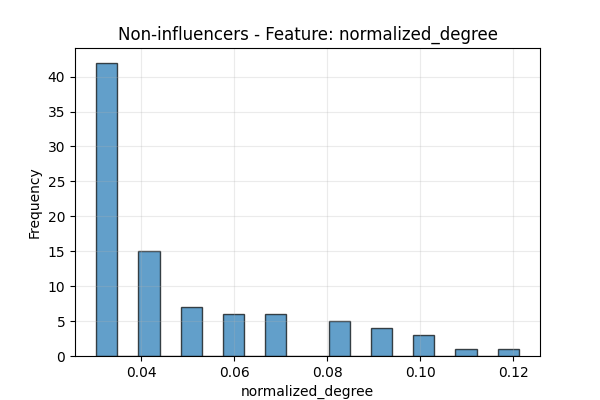

In [186]:
visualize_biker_data(G, isInfluencer=False, feature='normalized_degree', labels=labels)

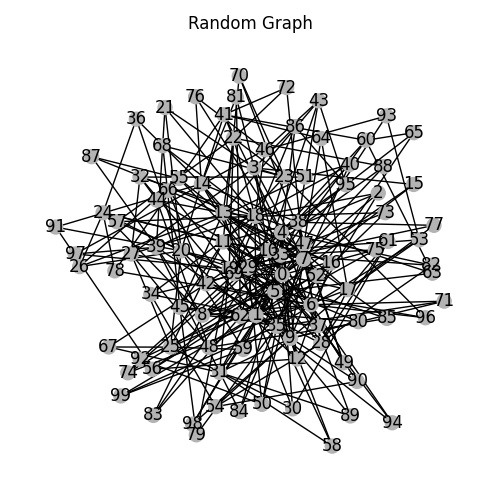

In [187]:
A = nx.to_numpy_array(G) # Get adjacency matrix from G
visualize_graph_bfs(A, k=0.8)

In [189]:
graph_to_csv(G, labels, "social_graph.csv")

Saved 100 rows to social_graph.csv
